In [ ]:

pip install requests beautifulsoup4 cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 2.0 MB/s eta 0:00:00


# Libraries

In [ ]:
pip install pyspark cloudscraper beautifulsoup4 nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install cloudscraper

In [ ]:
pip install pandas openpyxl

In [ ]:
python exportador.py

SyntaxError: invalid syntax (<ipython-input-25-26492665>, line 1)

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.functions import col, explode, split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Main

Acessando a URL base: https://stealthelook.com.br/?s=Perfume
Encontrados 10 links. Processando os primeiros 20.

Raspando artigo 1/20: Jean Paul Gaultier apresenta Scandal Intense em nova campanha

Raspando artigo 2/20: Os 14 melhores perfumes nacionais para você conhecer e testar

Raspando artigo 3/20: Conheça OLYMPÉA Absolu, a nova fragrância intensa de Rabanne

Raspando artigo 4/20: 8 perfumes masculinos para presentear seu par nesse Dia dos Namorados

Raspando artigo 5/20: Esse perfume feminino marcante vai fazer você se sentir uma milionária

Raspando artigo 6/20: Esse é o truque infalível para fazer o seu perfume durar mais

Raspando artigo 7/20: Carolina Herrera lança Very Good Girl Elixir, nova fragrância intensa

Raspando artigo 8/20: presentes de última hora perfeitos para as mães viciadas em beleza

Raspando artigo 9/20: Te contamos qual é perfume ideal para cada tipo de mãe

Raspando artigo 10/20: Valentino Beauty traz nova experiência olfativa ao Brasil

--- [PySpark] Bigr

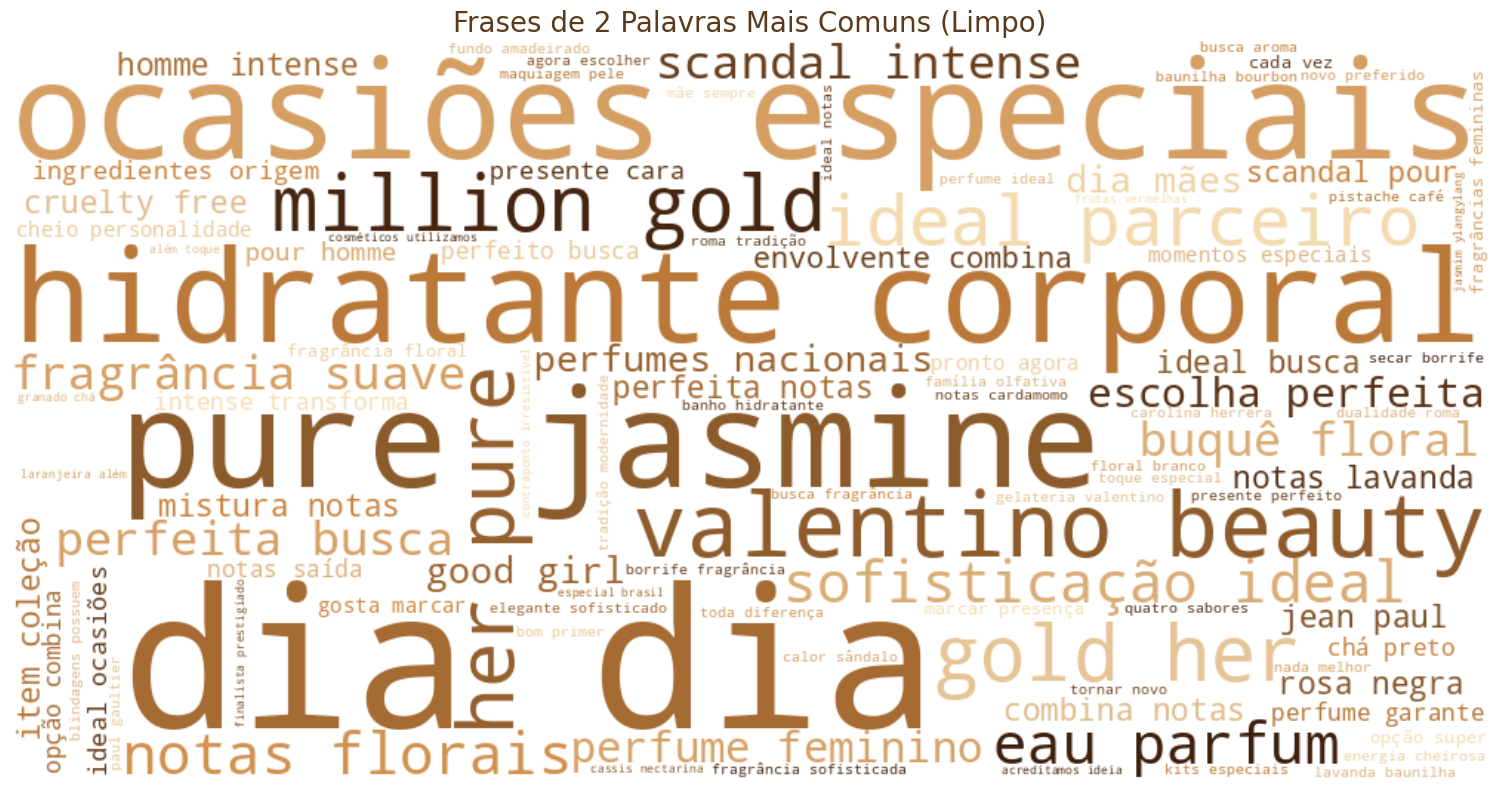

In [ ]:
#Stopwords
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

spark = SparkSession.builder.appName("StealTheLookPhraseFinder").getOrCreate()
sc = spark.sparkContext
stop_words_set = set(stopwords.words('portuguese'))
stop_words_set.update(['etc', 'aqui', 'ser', 'ter', 'ver'])

# --- ETAPA 1: SCRAPING E LIMPEZA ---
def scrape_articles(base_url, num_articles=15):
    articles_data = []
    scraper = cloudscraper.create_scraper()
    try:
        print(f"Acessando a URL base: {base_url}")
        response = scraper.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        article_links = soup.select('article.uk-article h2.title a')
        print(f"Encontrados {len(article_links)} links. Processando os primeiros {num_articles}.")
        for i, link in enumerate(article_links[:num_articles]):
            title = link.get_text(strip=True)
            url = link.get('href')
            if not url: continue
            print(f"\nRaspando artigo {i+1}/{num_articles}: {title}")
            try:
                article_response = scraper.get(url)
                article_response.raise_for_status()
                article_soup = BeautifulSoup(article_response.text, 'html.parser')
                content_div = article_soup.select_one('div.post-content')
                if content_div:
                    content = " ".join(p.get_text(strip=True) for p in content_div.find_all('p'))
                else:
                    content = " ".join(p.get_text(strip=True) for p in article_soup.find_all('p'))
                articles_data.append((title, url, content))
            except Exception as e:
                print(f"!!!!!! Erro ao raspar o artigo {url}: {e}")
    except Exception as e:
        print(f"!!!!!! Erro ao acessar a URL base {base_url}: {e}")
    return articles_data

def clean_text_for_spark(text):
    cleaned = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', '', text.lower())
    return " ".join([word for word in cleaned.split() if word not in stop_words_set and len(word) > 2])

def count_specific_terms(text, terms):
    counts = {}
    text_lower = text.lower()
    for term in terms:
        counts[term] = text_lower.count(term.lower())
    return counts

def plot_wordcloud(frequencies, title):
    if not frequencies: return
    filtered_freq = {k: v for k, v in frequencies.items() if v > 0}
    if not filtered_freq: return
    brown_cmap = LinearSegmentedColormap.from_list("brown_shades", ["#3e1f0d", "#8b5a2b", "#cd853f", "#deb887", "#f5deb3"])
    wc = WordCloud(width=1000, height=500, background_color='white', colormap=brown_cmap, max_words=150).generate_from_frequencies(filtered_freq)
    plt.figure(figsize=(16, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, color='#5a3a1a')
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":

    # NOVA LISTA DE TERMOS A SEREM EXCLUÍDOS
    boilerplate_phrases_to_exclude = [
        "saiba nossa política", "nossa política privacidade", "visitas melhorar experiência",
        "navegação saiba nossa", "melhorar experiência navegação", "estatísticas visitas melhorar",
        "cookies estatísticas visitas", "experiência navegação saiba", "utilizamos cookies estatísticas",
        "cookies estatísticas", "estatísticas visitas", "visitas melhorar", "melhorar experiência",
        "experiência navegação", "navegação saiba", "steal the look", "para melhorar sua", "melhorar sua experiência",
        "sua experiência navegação", "termos de uso", "política de privacidade", "saiba nossapolítica", "nossapolítica privacidade", "utilizamos cookies",
        "navegação saiba nossapolítica", "saiba nossapolítica privacidade", "busca perfume", "busca perfume feminino"
    ]

    target_url = "https://stealthelook.com.br/?s=Perfume"
    scraped_articles = scrape_articles(target_url, num_articles=20) # Aumentei para 20 para ter mais texto

    if not scraped_articles:
        print("Nenhum artigo foi raspado. Encerrando o script.")
        spark.stop()
        exit()

    all_raw_content_list = [article[2] for article in scraped_articles]
    all_raw_contents_combined = " ".join(all_raw_content_list)

    cleaned_texts = [clean_text_for_spark(content) for content in all_raw_content_list]
    df_cleaned = spark.createDataFrame([(text,) for text in cleaned_texts], ["cleaned_text"])
    tokenizer_cleaned = Tokenizer(inputCol="cleaned_text", outputCol="words")
    df_words = tokenizer_cleaned.transform(df_cleaned)

    # 2. Análise de N-grams com PySpark

    # BIGRAMAS (frases com 2 palavras)
    ngram_2 = NGram(n=2, inputCol="words", outputCol="bigrams")
    df_bigrams = ngram_2.transform(df_words)
    bigram_counts = df_bigrams.select(explode(col("bigrams")).alias("bigram")) \
                             .groupBy("bigram") \
                             .count() \
                             .filter(~col("bigram").isin(boilerplate_phrases_to_exclude)) \
                             .orderBy("count", ascending=False)
    print("\n--- [PySpark] Bigramas Mais Comuns (Resultados Limpos) ---")
    bigram_counts.show(20, truncate=False)

    # TRIGRAMAS (frases com 3 palavras)
    ngram_3 = NGram(n=3, inputCol="words", outputCol="trigrams")
    df_trigrams = ngram_3.transform(df_words)
    trigram_counts = df_trigrams.select(explode(col("trigrams")).alias("trigram")) \
                                .groupBy("trigram") \
                                .count() \
                                .filter(~col("trigram").isin(boilerplate_phrases_to_exclude)) \
                                .orderBy("count", ascending=False)

    print("\n--- [PySpark] Trigramas Mais Comuns (Resultados Limpos) ---")
    trigram_counts.show(20, truncate=False)


    # 3. Análise com Python: Contagem da sua lista específica de termos
    specific_terms_to_count = [
        "acessório", "amor próprio", "amadeirado", "autoestima", "autocuidado", "beleza",
        "beleza natural", "body splash", "Carolina Herrera", "cheiro de mulher rica",
        "cheiro marcante", "Chanel", "confiança", "conforto", "cosméticos",
        "desejo de consumo", "Dior", "dicas de beleza", "doce", "elegância", "elegante",
        "experiência", "feminilidade", "fixação forte", "Floral", "fragrância de luxo",
        "Frutado", "Gucci", "hidratação", "influenciadora", "intensidade do perfume",
        "item de desejo", "Lancôme", "lembrança", "lifestyle", "look", "looks", "luxo",
        "maquiagem", "Marcante", "melhores perfumes femininos", "memória", "moda", "necessaire",
        "Original", "pele", "perfume amadeirado", "perfume assinatura", "perfume com boa fixação",
        "perfume de mulher elegante", "perfume de mulher poderosa", "perfume doce",
        "perfume feminino mais elogiado", "perfume floral", "perfume importado original",
        "perfume para o dia a dia", "perfume que rende elogios", "perfume sedutor",
        "personalidade", "poder", "presente", "produto queridinho", "resenha", "rotina",
        "sensação", "sensual", "skincare", "sofisticado", "tendência", "tendências de beleza",
        "tendências de moda", "verão", "YSL"
    ]
    specific_terms_counts = count_specific_terms(all_raw_contents_combined, specific_terms_to_count)
    print("\n--- [Python] Contagem dos Termos Específicos da Sua Lista ---")
    count = 0
    for term, num in sorted(specific_terms_counts.items(), key=lambda item: item[1], reverse=True):
        if num > 0 and count < 20:
            print(f"'{term}': {num}")
            count += 1

    # 4. Visualização dos Resultados
    print("\n--- Gerando as Nuvens de Palavras ---")

    # Coleta os dados limpos para a nuvem de palavras
    bigrams_for_wordcloud = {row['bigram']: row['count'] for row in bigram_counts.take(100)}
    plot_wordcloud(bigrams_for_wordcloud, "Frases de 2 Palavras Mais Comuns (Limpo)")

    spark.stop()

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.functions import col, explode, split
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Stopwords
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

spark = SparkSession.builder.appName("StealTheLookExporter").getOrCreate()
sc = spark.sparkContext
stop_words_set = set(stopwords.words('portuguese'))
stop_words_set.update(['etc', 'aqui', 'ser', 'ter', 'ver'])

# --- ETAPA 1: SCRAPING E LIMPEZA ---
def scrape_articles(base_url, num_articles=15):
    articles_data = []
    scraper = cloudscraper.create_scraper()
    try:
        print(f"Acessando a URL base: {base_url}")
        response = scraper.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        article_links = soup.select('article.uk-article h2.title a')
        print(f"Encontrados {len(article_links)} links. Processando os primeiros {num_articles}.")
        for i, link in enumerate(article_links[:num_articles]):
            title = link.get_text(strip=True)
            url = link.get('href')
            if not url: continue
            print(f"\nRaspando artigo {i+1}/{num_articles}: {title}")
            try:
                article_response = scraper.get(url)
                article_response.raise_for_status()
                article_soup = BeautifulSoup(article_response.text, 'html.parser')
                content_div = article_soup.select_one('div.post-content')
                if content_div:
                    content = " ".join(p.get_text(strip=True) for p in content_div.find_all('p'))
                else:
                    content = " ".join(p.get_text(strip=True) for p in article_soup.find_all('p'))
                articles_data.append((title, url, content))
            except Exception as e:
                print(f"!!!!!! Erro ao raspar o artigo {url}: {e}")
    except Exception as e:
        print(f"!!!!!! Erro ao acessar a URL base {base_url}: {e}")
    return articles_data

def clean_text_for_spark(text):
    cleaned = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', '', text.lower())
    return " ".join([word for word in cleaned.split() if word not in stop_words_set and len(word) > 2])

def count_specific_terms(text, terms):
    counts = {}
    text_lower = text.lower()
    for term in terms:
        counts[term] = text_lower.count(term.lower())
    return counts

# A função de visualização permanece a mesma, mas não será chamada nesta versão para focar na exportação.
# Se quiser os gráficos, basta descomentar as chamadas no final.
def plot_wordcloud(frequencies, title):
    pass # Desativado para focar na exportação

if __name__ == "__main__":

    boilerplate_phrases_to_exclude = [
        "saiba nossa política", "nossa política privacidade", "visitas melhorar experiência",
        "navegação saiba nossa", "melhorar experiência navegação", "estatísticas visitas melhorar",
        "cookies estatísticas visitas", "experiência navegação saiba", "utilizamos cookies estatísticas",
        "cookies estatísticas", "estatísticas visitas", "visitas melhorar", "melhorar experiência",
        "experiência navegação", "navegação saiba", "steal the look", "para melhorar sua", "melhorar sua experiência",
        "sua experiência navegação", "termos de uso", "política de privacidade"
    ]

    target_url = "https://stealthelook.com.br/?s=Perfume"
    scraped_articles = scrape_articles(target_url, num_articles=20)

    if not scraped_articles:
        print("Nenhum artigo foi raspado. Encerrando o script.")
        spark.stop()
        exit()

    all_raw_content_list = [article[2] for article in scraped_articles]
    all_raw_contents_combined = " ".join(all_raw_content_list)

    cleaned_texts = [clean_text_for_spark(content) for content in all_raw_content_list]
    df_cleaned = spark.createDataFrame([(text,) for text in cleaned_texts], ["cleaned_text"])
    tokenizer_cleaned = Tokenizer(inputCol="cleaned_text", outputCol="words")
    df_words = tokenizer_cleaned.transform(df_cleaned)

    # Análise de N-grams com PySpark
    print("\n--- [PySpark] Processando Bigramas e Trigramas ---")
    ngram_2 = NGram(n=2, inputCol="words", outputCol="bigrams")
    df_bigrams = ngram_2.transform(df_words)
    bigram_counts = df_bigrams.select(explode(col("bigrams")).alias("bigram")) \
                             .groupBy("bigram").count() \
                             .filter(~col("bigram").isin(boilerplate_phrases_to_exclude)) \
                             .orderBy("count", ascending=False)

    ngram_3 = NGram(n=3, inputCol="words", outputCol="trigrams")
    df_trigrams = ngram_3.transform(df_words)
    trigram_counts = df_trigrams.select(explode(col("trigrams")).alias("trigram")) \
                                .groupBy("trigram").count() \
                                .filter(~col("trigram").isin(boilerplate_phrases_to_exclude)) \
                                .orderBy("count", ascending=False)
    print("Análise de N-grams concluída.")

    # Análise com Python
    print("\n--- [Python] Processando contagem de termos específicos ---")
    specific_terms_to_count = [
        "acessório", "amor próprio", "amadeirado", "autoestima", "autocuidado", "beleza",
        "beleza natural", "body splash", "Carolina Herrera", "cheiro de mulher rica",
        "cheiro marcante", "Chanel", "confiança", "conforto", "cosméticos",
        "desejo de consumo", "Dior", "dicas de beleza", "doce", "elegância", "elegante",
        "experiência", "feminilidade", "fixação forte", "Floral", "fragrância de luxo",
        "Frutado", "Gucci", "hidratação", "influenciadora", "intensidade do perfume",
        "item de desejo", "Lancôme", "lembrança", "lifestyle", "look", "looks", "luxo",
        "maquiagem", "Marcante", "melhores perfumes femininos", "memória", "moda", "necessaire",
        "Original", "pele", "perfume amadeirado", "perfume assinatura", "perfume com boa fixação",
        "perfume de mulher elegante", "perfume de mulher poderosa", "perfume doce",
        "perfume feminino mais elogiado", "perfume floral", "perfume importado original",
        "perfume para o dia a dia", "perfume que rende elogios", "perfume sedutor",
        "personalidade", "poder", "presente", "produto queridinho", "resenha", "rotina",
        "sensação", "sensual", "skincare", "sofisticado", "tendência", "tendências de beleza",
        "tendências de moda", "verão", "YSL"
    ]
    specific_terms_counts = count_specific_terms(all_raw_contents_combined, specific_terms_to_count)
    print("Contagem de termos específicos concluída.")

    # --- ETAPA 3: EXPORTAÇÃO PARA EXCEL ---

    print("\n--- Iniciando exportação para o arquivo Excel ---")
    output_filename = "analise_stealthelook.xlsx"

    # Converte os DataFrames do PySpark para DataFrames do Pandas
    pandas_bigrams_df = bigram_counts.toPandas()
    pandas_trigrams_df = trigram_counts.toPandas()

    sorted_specific_terms = sorted(specific_terms_counts.items(), key=lambda item: item[1], reverse=True)
    pandas_specific_df = pd.DataFrame(sorted_specific_terms, columns=['Termo', 'Contagem'])

    # Usa o ExcelWriter do Pandas para salvar cada DataFrame em uma aba diferente
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        pandas_bigrams_df.to_excel(writer, sheet_name='Bigramas Mais Comuns', index=False)
        print("Aba 'Bigramas Mais Comuns' salva.")

        pandas_trigrams_df.to_excel(writer, sheet_name='Trigramas Mais Comuns', index=False)
        print("Aba 'Trigramas Mais Comuns' salva.")

        pandas_specific_df.to_excel(writer, sheet_name='Contagem Termos Específicos', index=False)
        print("Aba 'Contagem Termos Específicos' salva.")

    print(f"\n✅ Dados exportados com sucesso para o arquivo: {output_filename}")

    # Encerra a sessão Spark
    spark.stop()

Acessando a URL base: https://stealthelook.com.br/?s=Perfume
Encontrados 10 links. Processando os primeiros 20.

Raspando artigo 1/20: Jean Paul Gaultier apresenta Scandal Intense em nova campanha

Raspando artigo 2/20: Os 14 melhores perfumes nacionais para você conhecer e testar

Raspando artigo 3/20: Conheça OLYMPÉA Absolu, a nova fragrância intensa de Rabanne

Raspando artigo 4/20: 8 perfumes masculinos para presentear seu par nesse Dia dos Namorados

Raspando artigo 5/20: Esse perfume feminino marcante vai fazer você se sentir uma milionária

Raspando artigo 6/20: Esse é o truque infalível para fazer o seu perfume durar mais

Raspando artigo 7/20: Carolina Herrera lança Very Good Girl Elixir, nova fragrância intensa

Raspando artigo 8/20: presentes de última hora perfeitos para as mães viciadas em beleza

Raspando artigo 9/20: Te contamos qual é perfume ideal para cada tipo de mãe

Raspando artigo 10/20: Valentino Beauty traz nova experiência olfativa ao Brasil

--- [PySpark] Proc

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql.functions import col, explode, split
import pandas as pd
import openpyxl

# -Stopwords
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')

spark = SparkSession.builder.appName("StealTheLookExporter").getOrCreate()
sc = spark.sparkContext
stop_words_set = set(stopwords.words('portuguese'))
stop_words_set.update(['etc', 'aqui', 'ser', 'ter', 'ver'])

# --- ETAPA 1: SCRAPING E LIMPEZA ---
def scrape_articles(base_url, num_articles=15):
    articles_data = []
    scraper = cloudscraper.create_scraper()
    try:
        print(f"Acessando a URL base: {base_url}")
        response = scraper.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        article_links = soup.select('article.uk-article h2.title a')
        print(f"Encontrados {len(article_links)} links. Processando os primeiros {num_articles}.")
        for i, link in enumerate(article_links[:num_articles]):
            title = link.get_text(strip=True)
            url = link.get('href')
            if not url: continue
            print(f"\nRaspando artigo {i+1}/{num_articles}: {title}")
            try:
                article_response = scraper.get(url)
                article_response.raise_for_status()
                article_soup = BeautifulSoup(article_response.text, 'html.parser')
                content_div = article_soup.select_one('div.post-content')
                if content_div:
                    content = " ".join(p.get_text(strip=True) for p in content_div.find_all('p'))
                else:
                    content = " ".join(p.get_text(strip=True) for p in article_soup.find_all('p'))
                articles_data.append((title, url, content))
            except Exception as e:
                print(f"!!!!!! Erro ao raspar o artigo {url}: {e}")
    except Exception as e:
        print(f"!!!!!! Erro ao acessar a URL base {base_url}: {e}")
    return articles_data

def clean_text_for_spark(text):
    cleaned = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', '', text.lower())
    return " ".join([word for word in cleaned.split() if word not in stop_words_set and len(word) > 2])

def count_specific_terms(text, terms):
    counts = {}
    text_lower = text.lower()
    for term in terms:
        counts[term] = text_lower.count(term.lower())
    return counts


if __name__ == "__main__":

    boilerplate_phrases_to_exclude = [
        "saiba nossa política", "nossa política privacidade", "visitas melhorar experiência",
        "navegação saiba nossa", "melhorar experiência navegação", "estatísticas visitas melhorar",
        "cookies estatísticas visitas", "experiência navegação saiba", "utilizamos cookies estatísticas",
        "cookies estatísticas", "estatísticas visitas", "visitas melhorar", "melhorar experiência",
        "experiência navegação", "navegação saiba", "steal the look", "para melhorar sua", "melhorar sua experiência",
        "sua experiência navegação", "termos de uso", "política de privacidade"
    ]

    target_url = "https://stealthelook.com.br/?s=Perfume"
    scraped_articles = scrape_articles(target_url, num_articles=20)

    if not scraped_articles:
        print("Nenhum artigo foi raspado. Encerrando o script.")
        spark.stop()
        exit()

    all_raw_content_list = [article[2] for article in scraped_articles]
    all_raw_contents_combined = " ".join(all_raw_content_list)

    cleaned_texts = [clean_text_for_spark(content) for content in all_raw_content_list]
    df_cleaned = spark.createDataFrame([(text,) for text in cleaned_texts], ["cleaned_text"])
    tokenizer_cleaned = Tokenizer(inputCol="cleaned_text", outputCol="words")
    df_words = tokenizer_cleaned.transform(df_cleaned)

    print("\n--- [PySpark] Processando Bigramas e Trigramas ---")
    ngram_2 = NGram(n=2, inputCol="words", outputCol="bigrams")
    df_bigrams = ngram_2.transform(df_words)
    bigram_counts = df_bigrams.select(explode(col("bigrams")).alias("bigram")) \
                             .groupBy("bigram").count() \
                             .filter(~col("bigram").isin(boilerplate_phrases_to_exclude)) \
                             .orderBy("count", ascending=False)

    ngram_3 = NGram(n=3, inputCol="words", outputCol="trigrams")
    df_trigrams = ngram_3.transform(df_words)
    trigram_counts = df_trigrams.select(explode(col("trigrams")).alias("trigram")) \
                                .groupBy("trigram").count() \
                                .filter(~col("trigram").isin(boilerplate_phrases_to_exclude)) \
                                .orderBy("count", ascending=False)
    print("Análise de N-grams concluída.")

    print("\n--- [Python] Processando contagem de termos específicos ---")
    specific_terms_to_count = [
        "acessório", "amor próprio", "amadeirado", "autoestima", "autocuidado", "beleza",
        "beleza natural", "body splash", "Carolina Herrera", "cheiro de mulher rica",
        "cheiro marcante", "Chanel", "confiança", "conforto", "cosméticos",
        "desejo de consumo", "Dior", "dicas de beleza", "doce", "elegância", "elegante",
        "experiência", "feminilidade", "fixação forte", "Floral", "fragrância de luxo",
        "Frutado", "Gucci", "hidratação", "influenciadora", "intensidade do perfume",
        "item de desejo", "Lancôme", "lembrança", "lifestyle", "look", "looks", "luxo",
        "maquiagem", "Marcante", "melhores perfumes femininos", "memória", "moda", "necessaire",
        "Original", "pele", "perfume amadeirado", "perfume assinatura", "perfume com boa fixação",
        "perfume de mulher elegante", "perfume de mulher poderosa", "perfume doce",
        "perfume feminino mais elogiado", "perfume floral", "perfume importado original",
        "perfume para o dia a dia", "perfume que rende elogios", "perfume sedutor",
        "personalidade", "poder", "presente", "produto queridinho", "resenha", "rotina",
        "sensação", "sensual", "skincare", "sofisticado", "tendência", "tendências de beleza",
        "tendências de moda", "verão", "YSL"
    ]
    specific_terms_counts = count_specific_terms(all_raw_contents_combined, specific_terms_to_count)
    print("Contagem de termos específicos concluída.")

    # --- ETAPA 3: EXPORTAÇÃO PARA EXCEL EM ABA ÚNICA ---

    print("\n--- Iniciando exportação para uma única aba do Excel ---")
    output_filename = "analise_consolidada_stealthelook.xlsx"

    # Converte os resultados para DataFrames do Pandas
    pandas_bigrams_df = bigram_counts.toPandas()
    pandas_trigrams_df = trigram_counts.toPandas()
    sorted_specific_terms = sorted(specific_terms_counts.items(), key=lambda item: item[1], reverse=True)
    pandas_specific_df = pd.DataFrame(sorted_specific_terms, columns=['Termo', 'Contagem'])

    # Usa o ExcelWriter para controlar a posição de cada tabela na mesma aba
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        # Define o nome da aba única
        sheet_name = 'Resultados Consolidados'

        # --- Tabela 1: Bigramas ---
        # Escreve o título da primeira tabela
        writer.sheets[sheet_name] = writer.book.create_sheet(sheet_name)
        worksheet = writer.sheets[sheet_name]
        worksheet['A1'] = 'Tabela 1: Bigramas Mais Comuns'
        worksheet['A1'].font = pd.io.excel.ExcelWriter._get_font(bold=True)
        pandas_bigrams_df.to_excel(writer, sheet_name=sheet_name, startrow=2, index=False)
        print(f"Tabela de Bigramas adicionada à aba '{sheet_name}'.")

        start_pos_trigrams = 2 + len(pandas_bigrams_df) + 3

        # --- Tabela 2: Trigramas ---
        worksheet.cell(row=start_pos_trigrams, column=1, value='Tabela 2: Trigramas Mais Comuns').font = pd.io.excel.ExcelWriter._get_font(bold=True)
        pandas_trigrams_df.to_excel(writer, sheet_name=sheet_name, startrow=start_pos_trigrams + 1, index=False)
        print(f"Tabela de Trigramas adicionada à aba '{sheet_name}'.")

        # Calcula a posição inicial da próxima tabela
        start_pos_specific = start_pos_trigrams + 1 + len(pandas_trigrams_df) + 3

        # --- Tabela 3: Termos Específicos ---
        worksheet.cell(row=start_pos_specific, column=1, value='Tabela 3: Contagem de Termos Específicos').font = pd.io.excel.ExcelWriter._get_font(bold=True)
        pandas_specific_df.to_excel(writer, sheet_name=sheet_name, startrow=start_pos_specific + 1, index=False)
        print(f"Tabela de Termos Específicos adicionada à aba '{sheet_name}'.")

    print(f"\n✅ Dados exportados com sucesso para o arquivo: {output_filename}")

    spark.stop()

Acessando a URL base: https://stealthelook.com.br/?s=Perfume
Encontrados 10 links. Processando os primeiros 20.

Raspando artigo 1/20: Jean Paul Gaultier apresenta Scandal Intense em nova campanha

Raspando artigo 2/20: Os 14 melhores perfumes nacionais para você conhecer e testar

Raspando artigo 3/20: Conheça OLYMPÉA Absolu, a nova fragrância intensa de Rabanne

Raspando artigo 4/20: 8 perfumes masculinos para presentear seu par nesse Dia dos Namorados

Raspando artigo 5/20: Esse perfume feminino marcante vai fazer você se sentir uma milionária

Raspando artigo 6/20: Esse é o truque infalível para fazer o seu perfume durar mais

Raspando artigo 7/20: Carolina Herrera lança Very Good Girl Elixir, nova fragrância intensa

Raspando artigo 8/20: presentes de última hora perfeitos para as mães viciadas em beleza

Raspando artigo 9/20: Te contamos qual é perfume ideal para cada tipo de mãe

Raspando artigo 10/20: Valentino Beauty traz nova experiência olfativa ao Brasil

--- [PySpark] Proc

AttributeError: type object 'ExcelWriter' has no attribute '_get_font'